# Vision Transformer

### By Jake Haugen for DS785

## Load Packages

In [1]:
#needed if running in Google Colab
!pip install vit-keras tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from vit_keras import vit, utils
import tensorflow_addons as tfa
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import gc

seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

#Needed if running in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Get the path to the brain tumor dataset
data_path = r'/content/drive/My Drive/Brain Tumor Data Set'

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive


## Define pre-processing and load in training/validation data

In [3]:
data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # normalize images
    validation_split=0.2,  #identify the percentage of images for validation
    rotation_range=15, #set the rotation of the images
    horizontal_flip=True, #flip images horizontally
    vertical_flip=True, #fliip images veritcally
    fill_mode='nearest' #nearest pixels used to fill empy areas. Other options are )Constant, Reflect, or Wrap)
)

In [4]:
batch_size = 16 #sets the batch size for the images

training = data.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary', #binary as we expect 2 classes
    color_mode='rgb',
    interpolation='bilinear', #used to resample
    subset='training',
    seed = 234, #set the random seed
    shuffle=True #shuffle images to limit overfitting
)

# Load the validation dataset
validation = data.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary', #binary as we expect 2 classes
    color_mode='rgb',
    interpolation='bilinear', #used to resample
    subset='validation',
    shuffle=False, #maintain consistency during validation checks
    seed = 234 #set the random seed

)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


(16, 224, 224, 3)


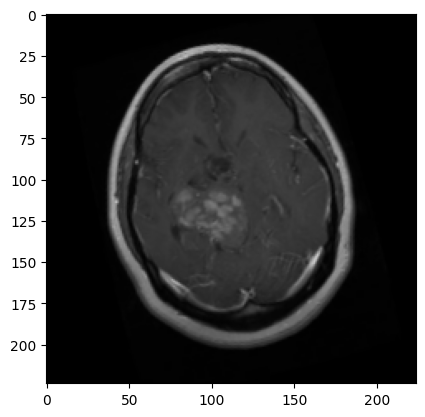

(16, 224, 224, 3)


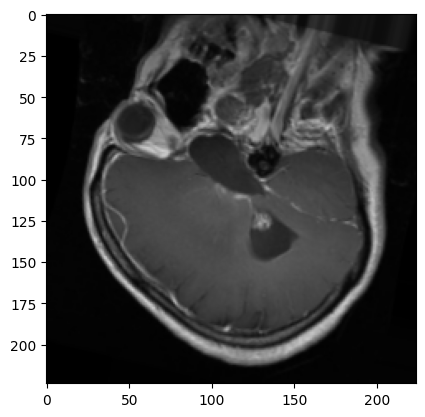

(16, 224, 224, 3)


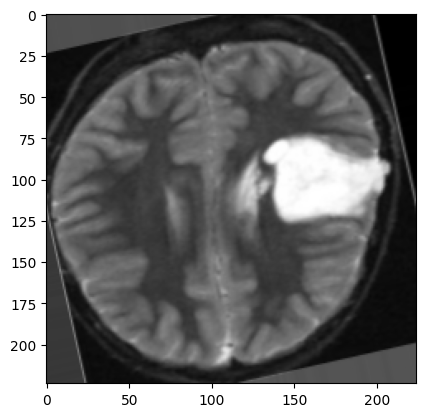

(16, 224, 224, 3)


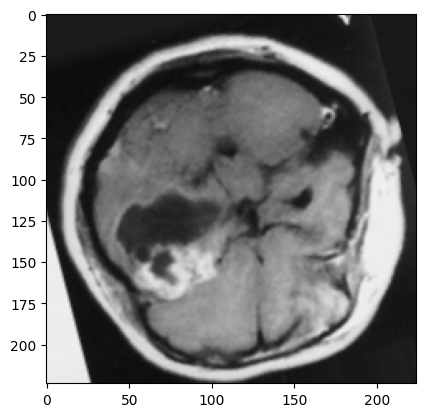

(16, 224, 224, 3)


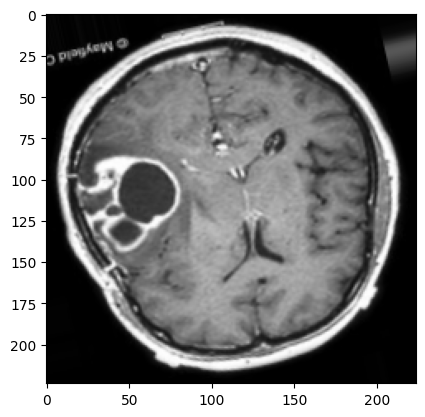

In [5]:
#display sample images of the validation brain images
for x in range(5):
    img, label = next(validation)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Define the Model

In [6]:
input_shape = (224, 224, 3)
image_size = 224
num_classes = 2

inputs = Input(shape=(224, 224, 3))
inputs = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs)
base_model = vit.vit_b16(image_size=224, activation="sigmoid", weights="imagenet21k+imagenet2012", pretrained=True,
                            include_top=False, pretrained_top=False)
base_model.trainable = False
x = base_model(inputs)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(32, activation=tfa.activations.gelu)(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="BinaryCrossentropy", metrics=["accuracy"])

#Create a summary of the compiled model
model.summary()


347502902/347502902 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                            

## Fit the Model

In [7]:
#To generate the full model, run without callbacks
model.fit(training,
          steps_per_epoch=200,
          epochs=80,
          validation_data=validation,
         )


Epoch 1/80
200/200 [==============================] - 999s 5s/step - loss: 0.4564 - accuracy: 0.7796 - val_loss: 0.3395 - val_accuracy: 0.8618
Epoch 2/80
200/200 [==============================] - 201s 1s/step - loss: 0.3181 - accuracy: 0.8662 - val_loss: 0.3182 - val_accuracy: 0.8629
Epoch 3/80
200/200 [==============================] - 105s 524ms/step - loss: 0.2557 - accuracy: 0.8972 - val_loss: 0.2753 - val_accuracy: 0.8847
Epoch 4/80
200/200 [==============================] - 100s 499ms/step - loss: 0.2368 - accuracy: 0.9052 - val_loss: 0.2549 - val_accuracy: 0.8825
Epoch 5/80
200/200 [==============================] - 101s 505ms/step - loss: 0.2180 - accuracy: 0.9130 - val_loss: 0.2263 - val_accuracy: 0.9042
Epoch 6/80
200/200 [==============================] - 98s 490ms/step - loss: 0.2175 - accuracy: 0.9133 - val_loss: 0.2466 - val_accuracy: 0.9010
Epoch 7/80
200/200 [==============================] - 99s 495ms/step - loss: 0.1819 - accuracy: 0.9284 - val_loss: 0.2370 - val_acc

In [8]:
#save the model for later use
model.save(r'/content/drive/My Drive/ViT.keras')
gc.collect()

4

## Generate Accuracy Metrics

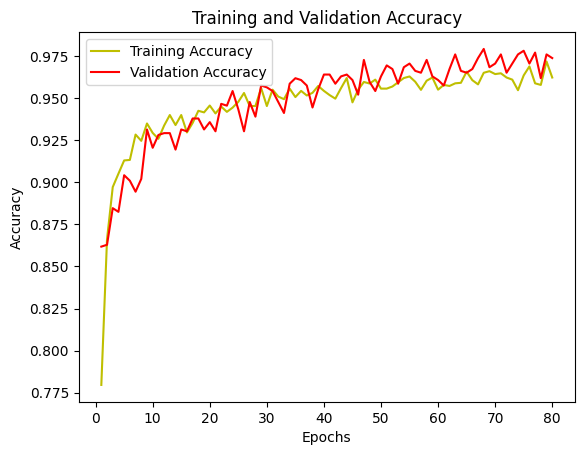

In [9]:
#plot the training and validation accuracy of each epoch
epochs = 80

accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Predict the values for the validation dataset
y_pred = model.predict(validation)

#Get predictions into a list
predictions = []
for i in y_pred:
  predictions.append(i[0])

#Set the predicted value based on the probability score
Y_pred = [0 if num < .5 else 1 for num in predictions]
Y_true = validation.classes

#Calculate the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

58/58 [==============================] - 26s 448ms/step


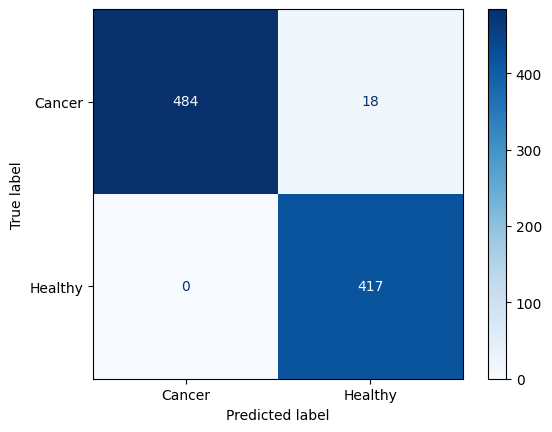

In [14]:
#Create the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx,
                             display_labels=['Cancer','Healthy'])
disp.plot(cmap='Blues')
plt.show()